In [1]:
import matplotlib.pyplot as plt
# ^^^ pyforest auto-imports - don't write above this line
import pandas as pd
import numpy as np
from nilearn import plotting, image, masking
from tqdm import tqdm
import seaborn  as sns
import ptitprince as pt
import matplotlib.colors as colors

/home/javi/Documentos/software/nilearn/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


Subjects used = 176
The minimum proportion of subjects without NaNs shouuld be 50.0%, which sets the maximum number of NaN's per voxel as = 87
number of grey matter voxels: 207584


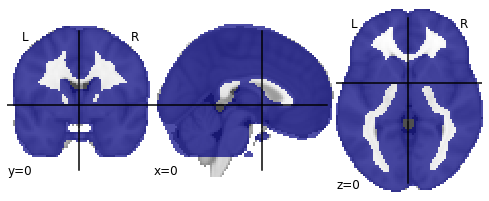

In [2]:
demo_data = pd.read_csv("../data/Thomas_Javi_ML_Share_PIP_Reappraisal_IMT_Longitudinal_02_NOV_2020.csv")
subject_fullsample =  demo_data.iloc[:,2].to_numpy()
print("Subjects used = %d" % len(subject_fullsample))

nan_props = 0.5
thr = len(subject_fullsample) - int(nan_props*len(subject_fullsample))
print("The minimum proportion of subjects without NaNs"
      " shouuld be %.1f%%, which sets the maximum number of NaN's per voxel as = %d" % (nan_props*100, thr-1)) 
# -1 in print here because the threshold is less than 

gm_mask = "../data/reslicedER_grey25grey25.nii" 
plotting.plot_roi(gm_mask, cut_coords=(0,0,0))
pass

gm_voxels = image.load_img(gm_mask).get_fdata().astype(bool).sum()
print("number of grey matter voxels: %d" % gm_voxels)

# Name for each contrast in the files
lookneg_vs_lookneut = "con_0001"
regneg_vs_lookneg = "con_0002"

# Define ranges of reliability according to Elliot's paper
poor_fair = (0.3, 0.6)
good_excel = (0.6)

# our ranges
moderate = [0.35,0.67]
high = [0.67]

In [3]:
def compute_consistency_map(contrast):
    er_1_half_pattern =  "../data/split_half_data/sub-%s/SplitHalf/ER_1stHalf/%s.nii"
    er_2_half_pattern =  "../data/split_half_data/sub-%s/SplitHalf/ER_2ndHalf/%s.nii"
    
    # Load split-half contrast images
    er_half_1 = image.load_img([er_1_half_pattern % (subj, contrast) for subj in subject_fullsample])
    er_half_2 = image.load_img([er_2_half_pattern % (subj, contrast) for subj in subject_fullsample])
    
    # OR gate, to indicate any voxel with a NaN
    nans_both = image.math_img("np.logical_or(img1, img2)", 
                               img1=image.math_img("np.isnan(img)", img=er_half_1),
                               img2=image.math_img("np.isnan(img)", img=er_half_2))
    
    # For each voxel, sum subjects with NaN and take only those under the permitted threshold
    nans_mask_data = np.sum(nans_both.get_fdata(), axis=3) < thr # less than, so the threshold is not taken
    nans_mask = image.new_img_like(nans_both, nans_mask_data)
    
    # Intersect this mask with grey matter mask
    mask_img = masking.intersect_masks([nans_mask, gm_mask], threshold=1)
    
    # Extract data within these masks
    er_half_1_flat = masking.apply_mask(er_half_1, mask_img, ensure_finite=False)    
    er_half_2_flat = masking.apply_mask(er_half_2, mask_img, ensure_finite=False)
    
    sb_reliability = np.zeros(er_half_1_flat.shape[1])
    for i_voxel, (x,y) in tqdm(enumerate(zip(er_half_1_flat.T, er_half_2_flat.T))):
    
        nan_x = np.isnan(x)
        nan_y = np.isnan(y)
        nan_cond = np.logical_or(nan_x, nan_y)

        # Compute Pearson Correlation (without NaN's)
        r = np.corrcoef(x[~nan_cond], y[~nan_cond])[0,1]

        # Apply Spearman-Brown correction
        r_corrected = (2*r)/(1+r)
        sb_reliability[i_voxel] = r_corrected
    
    neg_reliability = sum(sb_reliability<0)
    sb_reliability[sb_reliability<0]=0
    return masking.unmask(sb_reliability, mask_img), mask_img, neg_reliability

# Look Negative vs Look Neutral

203403it [00:15, 12959.00it/s]


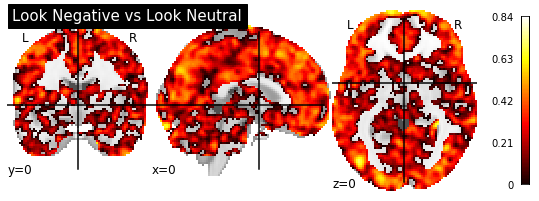

In [4]:
look_neg_reliability, effective_gm_mask_0001, neg_reliability_0001 = compute_consistency_map(lookneg_vs_lookneut)
plotting.plot_stat_map(look_neg_reliability, cut_coords=(0,0,0), title="Look Negative vs Look Neutral")

In [5]:
# Save to disk
look_neg_reliability.to_filename("../images/LookNeg_LookNeut_SpearmanBrown_reliability.nii.gz")
look_neg_reliability = image.load_img("../images/LookNeg_LookNeut_SpearmanBrown_reliability.nii.gz")

In [6]:
icc_values_0001 = masking.apply_mask(look_neg_reliability, effective_gm_mask_0001)

nan_voxels = gm_voxels-np.sum(effective_gm_mask_0001.get_fdata().astype(int))
print("Number of NaN voxels = %d (%.2f percentage)" % (nan_voxels, nan_voxels/gm_voxels*100))

n_voxels_poor= sum(icc_values_0001 <= 0.3)
print("number of voxels with null-to-poor reliability = %d (%.2f percentage)" % (n_voxels_poor, n_voxels_poor/gm_voxels*100))

n_voxels_fair = sum((icc_values_0001>0.3) & (icc_values_0001<=0.6))
print("number of voxels with poor-to-fair reliability = %d (%.2f percentage)" % (n_voxels_fair, n_voxels_fair/gm_voxels*100))

n_voxels_good = sum(icc_values_0001>0.6)
print("number of voxels with good-to-excellent reliability = %d (%.2f percentage)" % (n_voxels_good, n_voxels_good/gm_voxels*100))

print(nan_voxels + n_voxels_poor + n_voxels_fair + n_voxels_good)

Number of NaN voxels = 4181 (2.01 percentage)
number of voxels with null-to-poor reliability = 140609 (67.74 percentage)
number of voxels with poor-to-fair reliability = 62220 (29.97 percentage)
number of voxels with good-to-excellent reliability = 574 (0.28 percentage)
207584


truncated voxels: 28817 (14.17 percentage)
28817
vmax = 0.836337


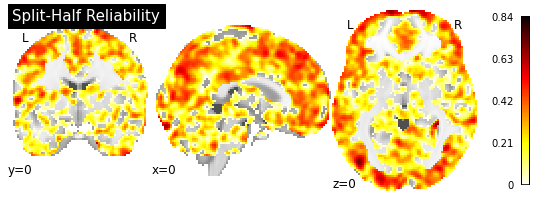

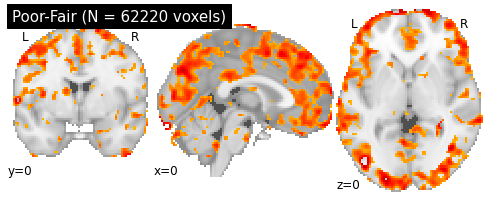

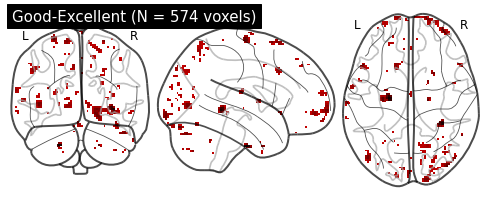

In [7]:
icc_values_0001 = masking.apply_mask(look_neg_reliability, effective_gm_mask_0001)
cmap = plotting.cm.cold_white_hot

plotting.plot_stat_map(look_neg_reliability, cut_coords=(0,0,0), title="Split-Half Reliability", 
                      cmap=cmap, draw_cross=False)
plt.savefig("../plots/split_half_reliabilities/look_neg_look_neut/look_neg_look_neut_reliability.svg", dpi=300)
plt.savefig("../plots/split_half_reliabilities/look_neg_look_neut/look_neg_look_neut_reliability.png", dpi=300)
plt.savefig("../plots/split_half_reliabilities/look_neg_look_neut/look_neg_look_neut_reliability.pdf", dpi=300)

print("truncated voxels: %d (%.2f percentage)" % (sum(icc_values_0001==0), 
                                              sum(icc_values_0001==0)/len(icc_values_0001)*100))
print(neg_reliability_0001)

# fig, ax = plt.subplots(figsize=(10, 5))
# #violin = pt.half_violinplot(look_neg_reliability.get_fdata()[look_neg_reliability.get_fdata()>0],  
#  #                  bw = .1, cut = 0,
#   #                 color="silver", linewidth=1, alpha=1,
#    #                scale = "area", width = .5, inner = None, orient = "h", ax=ax)
# violin = pt.half_violinplot(icc_values,  
#                    bw = .1, cut = 0,
#                    color="silver", linewidth=1, alpha=1,
#                    scale = "area", width = .5, inner = None, orient = "h", ax=ax)
# violin.collections[0].set_edgecolors('black')

# sns.boxplot(icc_values, 
#                color = "black", width = .10, zorder = 10,
#                showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
#                showfliers=True, whiskerprops = {'linewidth':2, "zorder":10},\
#                saturation = 1, orient = "h", ax=ax)
# plt.xlabel("Spearman-Brown adjusted \n Pearson correlations", size=25)
# plt.tick_params(labelsize=20)
# plt.ylim([0.1, -0.45])
# sns.despine(offset=0, trim=True, ax=ax)
# plt.tight_layout()
# plt.savefig("../plots/split_half_reliabilities/look_neg_look_neut/look_neg_look_neut_reliability_histo.svg", dpi=300)
# plt.savefig("../plots/split_half_reliabilities/look_neg_look_neut/look_neg_look_neut_reliability_histo.png", dpi=300)
# plt.savefig("../plots/split_half_reliabilities/look_neg_look_neut/look_neg_look_neut_reliability_histo.pdf", dpi=300)

vmax = look_neg_reliability.get_fdata().max()
print("vmax = %f" % vmax)

moderate_rel = image.math_img("img*((img > %f) & (img <= %f))" % poor_fair, img=look_neg_reliability)

n_voxels = np.sum(moderate_rel.get_fdata()>0)
plotting.plot_stat_map(moderate_rel, 
                       cmap=cmap,
                       vmax=vmax,
                       title="Poor-Fair (N = %d voxels)" % n_voxels,
                       draw_cross=False,
                       cut_coords = (0,0,0),
                       colorbar=False)

plt.savefig("../plots/split_half_reliabilities/look_neg_look_neut/look_neg_look_neut_reliability_fair.svg", dpi=300)
plt.savefig("../plots/split_half_reliabilities/look_neg_look_neut/look_neg_look_neut_reliability_fair.png", dpi=300)
plt.savefig("../plots/split_half_reliabilities/look_neg_look_neut/look_neg_look_neut_reliability_fair.pdf", dpi=300)

high_rel = image.math_img("img*(img > %f)" % good_excel, img=look_neg_reliability)
n_voxels = np.sum(high_rel.get_fdata()>0)

#plotting.plot_stat_map(high_rel, 
 #                      vmax=vmax,
  #                     cmap=cmap,
    #                   title="High (N = %d voxels)" % n_voxels,
      #                 colorbar=False)

plotting.plot_glass_brain(high_rel, 
                          vmax=vmax,
                          cmap=cmap,
                          title="Good-Excellent (N = %d voxels)" % n_voxels,
                          plot_abs=False,
                          colorbar=False)


plt.savefig("../plots/split_half_reliabilities/look_neg_look_neut/look_neg_look_neut_reliability_good.svg", dpi=300)
plt.savefig("../plots/split_half_reliabilities/look_neg_look_neut/look_neg_look_neut_reliability_good.png", dpi=300)
plt.savefig("../plots/split_half_reliabilities/look_neg_look_neut/look_neg_look_neut_reliability_good.pdf", dpi=300)

# Regulate Negative vs Look Negative

203403it [00:15, 13133.14it/s]


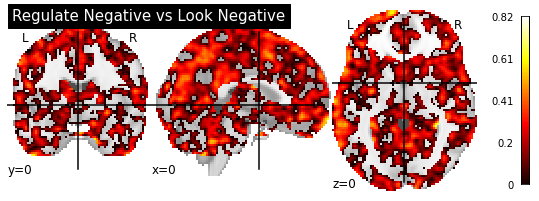

In [8]:
reap_neg_reliability, effective_gm_mask_0002, neg_reliability_0002 = compute_consistency_map(regneg_vs_lookneg)
plotting.plot_stat_map(reap_neg_reliability, cut_coords=(0,0,0), title="Regulate Negative vs Look Negative")

In [9]:
# Save to disk
reap_neg_reliability.to_filename("../images/RegNeg_LookNeg_SpearmanBrown_reliability.nii.gz")
from nilearn.image import load_img
reap_neg_reliability = load_img("../images/RegNeg_LookNeg_SpearmanBrown_reliability.nii.gz")

In [10]:
icc_values_0002 = masking.apply_mask(reap_neg_reliability, effective_gm_mask_0002)

nan_voxels = gm_voxels-np.sum(effective_gm_mask_0002.get_fdata().astype(int))
print("Number of NaN voxels = %d (%.2f percentage)" % (nan_voxels, nan_voxels/gm_voxels*100))

n_voxels_poor= sum(icc_values_0002 <= 0.3)
print("number of voxels with null-to-poor reliability = %d (%.2f percentage)" % (n_voxels_poor, n_voxels_poor/gm_voxels*100))

n_voxels_fair = sum((icc_values_0002>0.3) & (icc_values_0002<=0.6))
print("number of voxels with poor-to-fair reliability = %d (%.2f percentage)" % (n_voxels_fair, n_voxels_fair/gm_voxels*100))

n_voxels_good = sum(icc_values_0002>0.6)
print("number of voxels with good-to-excellent reliability = %d (%.2f percentage)" % (n_voxels_good, n_voxels_good/gm_voxels*100))

print(nan_voxels + n_voxels_poor + n_voxels_fair + n_voxels_good)

Number of NaN voxels = 4181 (2.01 percentage)
number of voxels with null-to-poor reliability = 179495 (86.47 percentage)
number of voxels with poor-to-fair reliability = 23866 (11.50 percentage)
number of voxels with good-to-excellent reliability = 42 (0.02 percentage)
207584


truncated voxels: 54529 (26.81 percentage)
54529
max = 0.819177


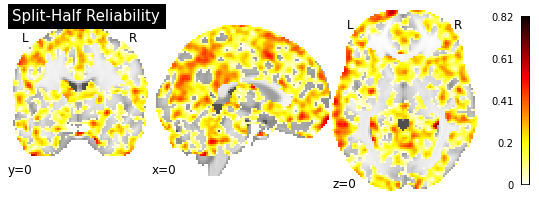

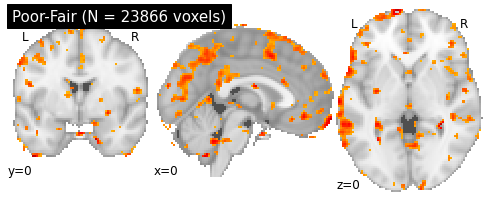

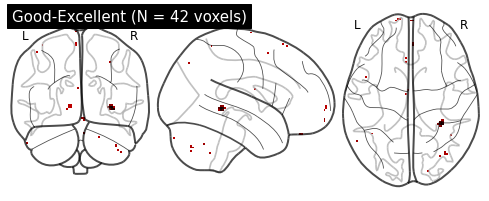

In [11]:
icc_values_0002 = masking.apply_mask(reap_neg_reliability, effective_gm_mask_0002)
cmap = plotting.cm.cold_white_hot

print("truncated voxels: %d (%.2f percentage)" % (sum(icc_values_0002==0), 
                                              sum(icc_values_0002==0)/len(icc_values_0002)*100))

print(neg_reliability_0002)

plotting.plot_stat_map(reap_neg_reliability, cut_coords=(0,0,0), title="Split-Half Reliability", 
                       draw_cross=False, cmap=cmap)
plt.savefig("../plots/split_half_reliabilities/reg_neg_look_neg/reg_neg_look_neg_reliability.svg", dpi=300)
plt.savefig("../plots/split_half_reliabilities/reg_neg_look_neg/reg_neg_look_neg_reliability.png", dpi=300)
plt.savefig("../plots/split_half_reliabilities/reg_neg_look_neg/reg_neg_look_neg_reliability.pdf", dpi=300)

# fig, ax = plt.subplots(figsize=(10, 5))

# violin = pt.half_violinplot(icc_values,  
#                    bw = .1, cut = 0,
#                    color="silver", linewidth=1, alpha=1,
#                    scale = "area", width = .5, inner = None, orient = "h", ax=ax)

# violin.collections[0].set_edgecolors('black')

# sns.boxplot(icc_values, 
#                color = "black", width = .10, zorder = 10,
#                showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
#                showfliers=True, whiskerprops = {'linewidth':2, "zorder":10},\
#                saturation = 1, orient = "h", ax=ax)
# plt.xlabel("Spearman-Brown adjusted \n Pearson correlations", size=25)
# plt.tick_params(labelsize=20)
# plt.ylim([0.1, -0.45])
# sns.despine(offset=0, trim=True, ax=ax)
# plt.tight_layout()
# plt.savefig("../plots/split_half_reliabilities/reg_neg_look_neg/reg_neg_look_neg_reliability_histo.svg", dpi=300)
# plt.savefig("../plots/split_half_reliabilities/reg_neg_look_neg/reg_neg_look_neg_reliability_histo.png", dpi=300)
# plt.savefig("../plots/split_half_reliabilities/reg_neg_look_neg/reg_neg_look_neg_reliability_histo.pdf", dpi=300)

vmax = reap_neg_reliability.get_fdata().max()
print("max = %f" % vmax)
moderate_rel = image.math_img("img*((img > %f) & (img <= %f))" % (0.3, 0.6), img=reap_neg_reliability)

n_voxels = np.sum(moderate_rel.get_fdata()>0)
plotting.plot_stat_map(moderate_rel, 
                       vmax=vmax,
                       cmap = cmap,
                       cut_coords = (0,0,0),
                       draw_cross=False,
                       title="Poor-Fair (N = %d voxels)" % n_voxels,
                       colorbar=False)

plt.savefig("../plots/split_half_reliabilities/reg_neg_look_neg/reg_neg_look_neg_reliability_fair.svg", dpi=300)
plt.savefig("../plots/split_half_reliabilities/reg_neg_look_neg/reg_neg_look_neg_reliability_fair.png", dpi=300)
plt.savefig("../plots/split_half_reliabilities/reg_neg_look_neg/reg_neg_look_neg_reliability_fair.pdf", dpi=300)

high_rel = image.math_img("img*(img > %f)" % (0.6), img=reap_neg_reliability)
n_voxels = np.sum(high_rel.get_fdata()>0)

plotting.plot_glass_brain(high_rel, 
                          vmax=vmax,
                          cmap=cmap,
                          title="Good-Excellent (N = %d voxels)" % n_voxels,
                          plot_abs=False,
                          colorbar=False)

plt.savefig("../plots/split_half_reliabilities/reg_neg_look_neg/reg_neg_look_neg_reliability_good.svg", dpi=300)
plt.savefig("../plots/split_half_reliabilities/reg_neg_look_neg/reg_neg_look_neg_reliability_good.png", dpi=300)
plt.savefig("../plots/split_half_reliabilities/reg_neg_look_neg/reg_neg_look_neg_reliability_good.pdf", dpi=300)

# Plot ICC effect sizes both together

In [12]:
icc_df = pd.melt(pd.DataFrame({"Look Negative vs Look Neutral": icc_values_0001, 
                               "Regulate Negative vs Look Negative": icc_values_0002}))

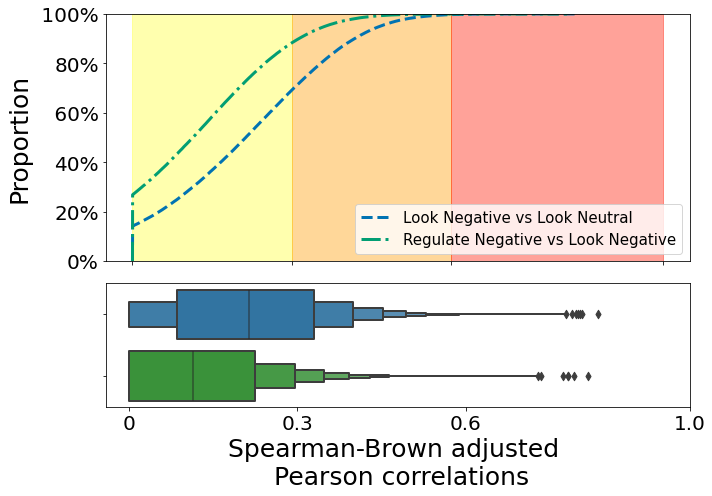

In [15]:
from matplotlib import gridspec

fig  = plt.figure(figsize=(10, 7))
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])


ax1 = fig.add_subplot(gs[1])
ax0 = fig.add_subplot(gs[0])

sns.set_palette(palette=[sns.color_palette("tab10")[0], sns.color_palette("tab10")[2]])

#fig, axs = plt.subplots(figsize=(10,7), nrows=2, sharex=True)
sns.ecdfplot(icc_values_0001, label="Look Negative vs Look Neutral", ax=ax0, 
             color=sns.color_palette("colorblind")[0],
             linestyle="--",
            linewidth=3)
sns.ecdfplot(icc_values_0002, label="Regulate Negative vs Look Negative",  
             color=sns.color_palette("colorblind")[2], 
             linestyle="-.", linewidth=3, ax=ax0)
ax0.set_xticks([0,0.3, 0.6, 1.0])
ax0.set_xticklabels("")
ax0.set_ylabel("Proportion", size=25)
ax0.set_yticks([0,0.2, 0.4, 0.6, 0.8, 1.0])
ax0.set_yticklabels(["0%","20%", "40%"," 60%", "80%"," 100%"], size=20)
ax0.legend(fontsize=15)
ax0.axvspan(0,0.3, alpha=0.4, color=cmap(0.6))
ax0.axvspan(0.3,0.6, alpha=0.4, color=cmap(0.7))
ax0.axvspan(0.6, 1, alpha=0.4, color=cmap(0.8))
#sns.set_style(style="default", rc= {'patch.edgecolor': 'black'})

bplot = sns.boxenplot(y="variable", x="value", data=icc_df, ax=ax1, linewidth=2)

ax1.set_ylabel("")
ax1.set_yticklabels("")
ax1.set_xticks([0,0.3, 0.6, 1.0])
ax1.set_xticklabels(["0","0.3", "0.6", "1.0"], size=20)
ax1.set_xlabel("Spearman-Brown adjusted \n Pearson correlations", size=25)

plt.tight_layout()
plt.savefig("../plots/split_half_reliabilities/icc_ecdf_boxplot.svg", dpi=300)
plt.savefig("../plots/split_half_reliabilities/icc_ecdf_boxplot.pdf", dpi=300)
plt.savefig("../plots/split_half_reliabilities/icc_ecdf_boxplot.png", dpi=300)

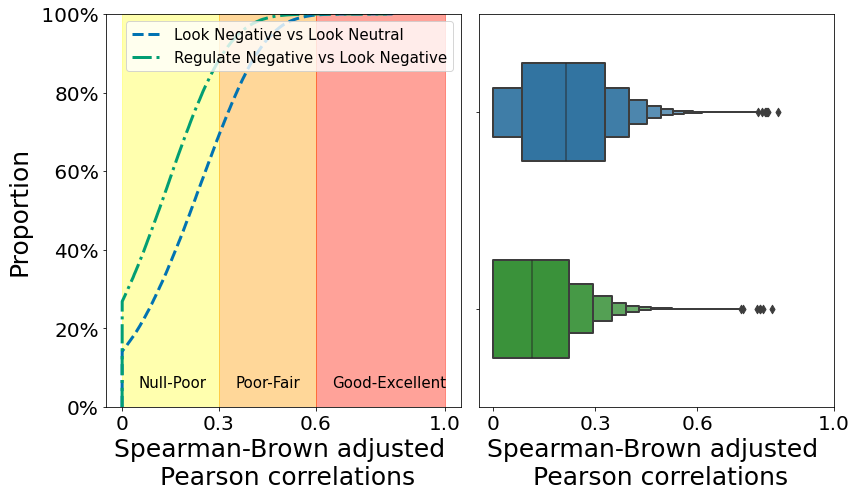

In [51]:
from matplotlib import gridspec

fig  = plt.figure(figsize=(12, 7))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])


ax1 = fig.add_subplot(gs[1])
ax0 = fig.add_subplot(gs[0])

sns.set_palette(palette=[sns.color_palette("tab10")[0], sns.color_palette("tab10")[2]])

#fig, axs = plt.subplots(figsize=(10,7), nrows=2, sharex=True)
sns.ecdfplot(icc_values_0001, label="Look Negative vs Look Neutral", ax=ax0, 
             color=sns.color_palette("colorblind")[0],
             linestyle="--",
            linewidth=3)
sns.ecdfplot(icc_values_0002, label="Regulate Negative vs Look Negative",  
             color=sns.color_palette("colorblind")[2], 
             linestyle="-.", linewidth=3, ax=ax0)
ax0.set_xticks([0,0.3, 0.6, 1.0])
ax0.set_xticklabels("")
ax0.set_ylabel("Proportion", size=25)
ax0.set_yticks([0,0.2, 0.4, 0.6, 0.8, 1.0])
ax0.set_yticklabels(["0%","20%", "40%"," 60%", "80%"," 100%"], size=20)
ax0.legend(fontsize=15,loc="upper right")
ax0.axvspan(0,0.3, alpha=0.4, color=cmap(0.6))
ax0.axvspan(0.3,0.6, alpha=0.4, color=cmap(0.7))
ax0.axvspan(0.6, 1, alpha=0.4, color=cmap(0.8))
ax0.set_xticks([0,0.3, 0.6, 1.0])
ax0.set_xticklabels(["0","0.3", "0.6", "1.0"], size=20)
ax0.set_xlabel("Spearman-Brown adjusted \n Pearson correlations", size=25)
ax0.annotate("Null-Poor", (0.05, 0.05), fontsize=15)
ax0.annotate("Poor-Fair", (0.35, 0.05), fontsize=15)
ax0.annotate("Good-Excellent", (0.65, 0.05), fontsize=15)
bplot = sns.boxenplot(y="variable", x="value", data=icc_df, ax=ax1, linewidth=2, width=0.5)

ax1.set_xticks([0,0.3, 0.6, 1.0])
ax1.set_xticklabels(["0","0.3", "0.6", "1.0"], size=20)
ax1.set_xlabel("Spearman-Brown adjusted \n Pearson correlations", size=25)

ax1.set_ylabel("")
ax1.set_yticklabels("")
#ax1.yaxis.tick_right()
#ax1.yaxis.set_label_position("right")

plt.tight_layout()
plt.savefig("../plots/split_half_reliabilities/icc_ecdf_boxplot.svg", dpi=300)
plt.savefig("../plots/split_half_reliabilities/icc_ecdf_boxplot.pdf", dpi=300)
plt.savefig("../plots/split_half_reliabilities/icc_ecdf_boxplot.png", dpi=300)

In [59]:
print("Look Negative vs Look Neutral- Q1: %.3f, Q2: %.3f, Q3: %.3f," % tuple(np.quantile(icc_values_0001, 
                                                                                         q=[0.25, 0.5, 0.75])), 
      "max: %.3f"% max(icc_values_0001))
print("Regulate Negative vs Look Negative- Q1: %.3f, Q2: %.3f, Q3: %.3f," % tuple(np.quantile(icc_values_0002, 
                                                                                               q=[0.25, 0.5, 0.75])), 
      "max: %.3f"% max(icc_values_0002))

Look Negative vs Look Neutral- Q1: 0.084, Q2: 0.213, Q3: 0.329, max: 0.836
Regulate Negative vs Look Negative- Q1: 0.000, Q2: 0.114, Q3: 0.224, max: 0.819


In [62]:
print(sum(icc_values_0001==0.0)/len(icc_values_0001))
print(sum(icc_values_0002==0.0)/len(icc_values_0001))

0.14167440991529132
0.26808355825626956


In [61]:
print(sum(icc_values_0001<0.3)/len(icc_values_0001))
print(sum(icc_values_0002<0.3)/len(icc_values_0001))

0.691282822770559
0.8824599440519559
